In [1]:
from random import choices
from tools import *
import tools
import matplotlib.pyplot as plt
import tools
import ms
import os
import seaborn as sns
import numpy as np
import torch
import re
from tqdm import tqdm
from importlib import reload
import bio_helper
import math
import sys
import pandas as pd
from collections import defaultdict
sys.path.append("..")
# plt.style.use(['science', 'ieee', 'high-vis', 'no-latex'])
%load_ext autoreload
%autoreload 2

def to_tensor(frag_msms):
    frag_msms = [i.reshape(1, -1) for i in frag_msms]
    frag_msms = np.concatenate(frag_msms, axis=0)
    # frag_msms /= frag_msms.max()
    return torch.from_numpy(frag_msms)
# name, msms_data = read_msms(
#     "/data/prosit/test/fig3a/pick_msms.txt")


def read_ions(msms, name):
    i_index = name.index("Intensities")
    m_index = name.index("Matches")
    mass_index = name.index("Masses")
    return [(i[m_index].split(";"), i[i_index].split(";"), i[mass_index].split(";")) for i in msms]


In [2]:
name, msms_data = tools.read_msms(
    f"/data/prosit/figs/fig235/trypsin/maxquant/combined/txt/msms.txt")
msms_data = tools.filter_msms(name, msms_data)

msms_data = msms_data[:10000]


In [3]:
msms_data.sort(key=lambda x: int(x[name.index("id")]))
m_r = loc_msms_in_raw(msms_data, f"/data/prosit/figs/fig235/trypsin/raw")
m_r = sorted(m_r, key=lambda x: int(x[0][name.index("id")]))
print(len(m_r))


10000


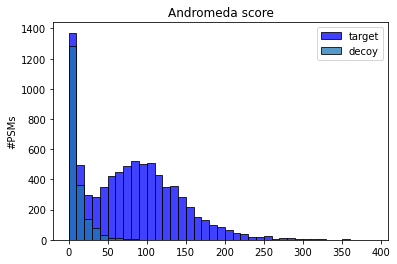

In [4]:
scores = np.array([float(m[0][name.index("Score")]) for m in m_r])
label = np.array([0 if m[0][name.index("Reverse")] else 1 for m in m_r])

sns.histplot([s for s, l in zip(scores, label)
             if l == 1], binwidth=10, label="target", color="blue")
ax = sns.histplot([s for s, l in zip(scores, label) if l == 0],
                  binwidth=10, label="decoy")
ax.set(ylabel="#PSMs", title="Andromeda score")
plt.legend()


In [5]:
from ms import model
import ms

run_model = model.TransProBest()
run_model.load_state_dict(torch.load(
    "../checkpoints/frag/nce/best_nce_frag_TransPro-6-3-128-0.1-256-512-0.1-0.3.pth", map_location="cpu"))
trans_model = run_model.eval()

run_model = model.PrositFrag()
run_model.load_state_dict(torch.load(
    "../checkpoints/best/best_valid_irt_PrositFrag-1024.pth", map_location="cpu"))
prosit = run_model.eval()


In [6]:
matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_pre)]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]
ratio = np.array([i[4] for i in tqdm(m_i)])
scale = np.array([i[6] for i in tqdm(m_i)])


100%|██████████| 10000/10000 [00:00<00:00, 5029141.49it/s]


In [60]:
frag_msms_np = np.array(frag_msms).reshape(len(label), -1)
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)
prosit_sa, prosit_tensor = get_sa_all_scale(prosit, data_nce_cand, frag_msms, scale)
prosit_sa = prosit_sa.cpu().numpy()
prosit_tensor = prosit_tensor.cpu().numpy()

prosit_sa[np.isnan(prosit_sa)] = 1

In [64]:
frag_msms_np = np.array(frag_msms).reshape(len(label), -1)
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)
prosit_sa, prosit_tensor = get_sa_all(
    prosit, data_nce_cand, frag_msms)
prosit_sa = prosit_sa.cpu().numpy()
prosit_tensor = prosit_tensor.cpu().numpy()

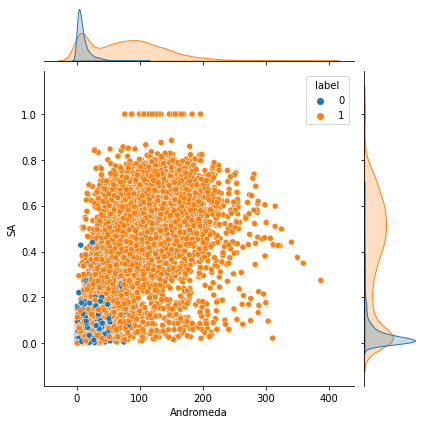

In [50]:
joint_pd = pd.DataFrame({"SA": prosit_sa, "Andromeda": scores, "label": label})
# ax = sns.jointplot(x="label", y='length', data=joint_pd)
sns.jointplot(x="Andromeda", y="SA",data=joint_pd, hue="label")

In [ ]:
matched_ions_rever = generate_matched_ions_reverse(m_r)
m_i_rever = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_rever)]
frag_msms_rever = [bio_helper.reverse_annotation(
    *i[:4]) for i in tqdm(m_i_rever)]
ratio_rever = np.array([i[4] for i in tqdm(m_i_rever)])

frag_msms_np_rever = np.array(frag_msms_rever).reshape(len(label), -1)
data_nce_cand = generate_from_mi(matched_ions_rever, name, nces=33)
prosit_sa_rever, prosit_tensor_rever = get_sa_all(prosit, data_nce_cand, frag_msms_rever)
prosit_sa_rever = prosit_sa_rever.cpu().numpy()
prosit_tensor_rever = prosit_tensor_rever.cpu().numpy()


In [ ]:
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)
trans_sa, trans_tensor = get_sa_all(trans_model, data_nce_cand, frag_msms)
trans_sa = trans_sa.cpu().numpy()
trans_tensor = trans_tensor.cpu().numpy()

In [67]:
def create_peak(mz, inten):
    new_mz = []
    new_inten = []
    for m, i in zip(mz, inten):
        new_mz.append(m)
        new_inten.append(i)
        for j in range(100):
            new_mz.append(m)
            new_inten.append(j/100 * i)
    return new_mz, new_inten

def plot_mz(match):
    mz = bio_helper.read_attribute(match, 'masses_raw')
    inten = bio_helper.read_attribute(match, 'intensities_raw')
    return create_peak(mz, inten)

prosit_sa = prosit_sa*ratio

sa_bad = prosit_sa[label == 0]
sa_good = prosit_sa[label == 1]
# sa_bad_rever = prosit_sa_rever[label == 0]

frag_bad = frag_msms_np[label == 0]
frag_bad = (frag_bad/((frag_bad**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))
pred_frag_bad = prosit_tensor[label == 0]
pred_frag_bad = (
    pred_frag_bad/((pred_frag_bad**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))

# frag_bad_rever = frag_msms_np_rever[label == 0]
# frag_bad_rever = (frag_bad_rever/((frag_bad_rever**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))
# pred_frag_bad_rever = prosit_tensor_rever[label == 0]
# pred_frag_bad_rever = (
#     pred_frag_bad_rever/((pred_frag_bad_rever**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))

order = np.argsort(-sa_bad)

i=0
# plt.plot(frag_bad[order[i]] + 1)
# plt.plot(pred_frag_bad[order[i]])
# plt.plot(frag_bad_rever[order[i]] + 3)
# plt.plot(pred_frag_bad_rever[order[i]]+2)
# plt.scatter(*plot_mz(matched_ions_pre[order[i]]), s=2, alpha=0.6)
# plt.scatter(*create_peak(m_i[order[i]][5], m_i[order[i]][1]), s=1, label='norm')
# plt.scatter(*create_peak(m_i_rever[order[i]][5], m_i[order[i]][1]), s=1, label='rever')
# plt.legend()
# plt.plot(sa_bad[order])
# plt.scatter(range(len(order)), s=2)
print(sa_bad[order[i]])
print(np.mean(sa_good < sa_bad[order[i]]))
# print(sa_bad_rever[order[i]])


0.27732063758464304
0.9502167182662539


In [ ]:
mask = np.logical_and(label == 1, scores > 50)
sa_good = prosit_sa[mask]
sa_good_rever = prosit_sa_rever[mask]
and_good = scores[mask]
frag_bad = frag_msms_np[mask]
frag_good = (frag_bad/((frag_bad**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))
pred_frag_bad = prosit_tensor[mask]
pred_frag_good = (
    pred_frag_bad/((pred_frag_bad**2).sum(1).reshape(-1, 1)**0.5 + 1e-9))

order = np.argsort(sa_good)

i = 0
plt.plot(sa_good[order])
plt.scatter(range(len(order)), sa_good_rever[order], s=2)
# plt.plot(frag_good[order[i]] + 1)
# plt.plot(pred_frag_good[order[i]])
# plt.plot(sa_good[order])
# plt.plot(and_good[order])
print(sa_good[order[i]])
print(and_good[order[i]])
# print(frag_good[order[i]], pred_frag_good[order[i]])


In [ ]:
import pandas as pd

# prosit_sa_random[prosit_sa >= prosit_sa_random] = 0
prosit_sa_rule = np.copy(prosit_sa_rever)
prosit_sa_rule[(prosit_sa) < prosit_sa_rever] = 0

joint_pd = pd.DataFrame({"sa": prosit_sa, "and": prosit_sa - prosit_sa_rule,
                        "label": ['decoy' if m[0][name.index("Reverse")] else "target" for m in m_r]})

ax = sns.jointplot(x="and", y='sa', data=joint_pd, hue='label')
ax.set_axis_labels('Andromeda', 'SA')

print(np.mean((prosit_sa*ratio)[label == 1] < (prosit_sa*ratio)[label == 0].max()))
delta = prosit_sa*ratio - prosit_sa_rever*ratio_rever
print(np.mean(delta[label == 1] < delta[label == 0].max()))
# sns.histplot(x="and", data=joint_pd, hue='label')


In [ ]:
joint_pd = pd.DataFrame({"sa": prosit_sa*ratio, "and": scores*ratio,
                        "label": ['decoy' if m[0][name.index("Reverse")] else "target" for m in m_r]})
sns.histplot(x="sa", data=joint_pd, hue='label')
# sns.histplot(x="and", data=joint_pd, hue='label')


In [ ]:
sns.histplot(x="and", data=joint_pd, hue='label')


In [ ]:
print(label[ratio < ratio_rever].mean())
print(label[prosit_sa < prosit_sa_rever].mean())
print(label[prosit_sa*ratio < prosit_sa_rever*ratio_rever].mean())


In [ ]:
non_count = np.count_nonzero(prosit_tensor, axis=1)

plt.scatter(non_count,prosit_sa)


In [ ]:
non_count = np.count_nonzero(frag_msms_np, axis=1)

plt.scatter(non_count,prosit_sa)